# cnn for nft appraisal

---

## todo
~~1. web scraping from opensea~~

1. downloading from nftshowroom
2. storing into db (mongodb/sqlite)
3. extracting data for train/val/test
4. custom cnn model / pretrained model
5. dense(1) + mse for continuous output prediction
6. testing model
7. ??????? flask for model deployment online

## problems
* web scraping from opensea failed due to cloudflare protection
* opensea api also not good for retrieving large amounts of nfts
  * more for analyzing specific collections or market events
* found kaggle dataset with script provided to scrape from nftshowroom instead

## nftshowroom data
`https://cdn.nftshowroom.com/`
* required info
  1. title ('collection')
  1. name
  1. 
  
## sqlite3 vs csv
* csv is good but want to try sqlite
* db can prevent duplicates (using the cid) when downloading more images
* db can allow updates to image metadata like price, likes

## streamlit
`>> streamlit run my-code.py`

In [ ]:
from enum import Enum, auto


class SortBy(Enum):
    """Sorting options for the downloader"""

    UPDATED = "updated"
    NEWST = "newest"
    OLDEST = "oldest"
    PRICE_ASC = "price_asc"  # Cheapest
    PRICE_DESC = "price_desc"  # Most expensive


class ArtType(Enum):
    VIDEO = auto()  # Only avi, mp4, mov etc
    PHOTO = auto()  # Only  png, jpeg, jpg etc
    GIF = auto()  # Only .gif
    IMAGE = GIF | PHOTO  # IMAGE = PHOTO + GIF
    ALL = GIF | PHOTO | VIDEO  # ALL = IMAGE + VIDEO


def remove_nsfw(rows: list) -> str:
    for row in rows:
        if row["nsfw"] == True:
            rows.remove(row)

    return rows


def get_art_type(row) -> ArtType:
    if row["image"] == None:
        return ArtType.VIDEO
    elif row["image"].endswith(".gif"):
        return ArtType.GIF
    else:
        return ArtType.PHOTO


def assign_art_types(rows: list) -> list:
    for row in rows:
        art_type = get_art_type(row)
        row["type"] = art_type
    return rows


def retrieve_art_metadata(page: int = 1, limit: int = 100, sort_by: SortBy = SortBy.UPDATED) -> list:
    url = f"https://nftshowroom.com/api/market?page={page}&limit={limit}&sort_by={sort_by.value}"

    request = requests.get(url)
    if request.status_code != 200:
        raise Exception("Status code isn't 200")

    return request.json()


def download_art_piece(
    piece, master_dir: str = "./dataset", video_dir: str = "video", image_dir: str = "image", gif_dir: str = "gif"
) -> str:
    """The art type needs to be assigned"""

    # Video and images are stored in different places
    if piece["type"] == ArtType.VIDEO:
        url = piece["video"]
    else:
        url = piece["image"]

    # Create a path based on the cid and the given file extension
    # This is done since kaggle doesn't allow "strange" chars in the the file names.
    file_name = "".join([piece["cid"], ".", url.split(".")[-1]])

    directories = {
        ArtType.PHOTO: image_dir,
        ArtType.GIF: gif_dir,
        ArtType.VIDEO: video_dir,
    }

    # Create a local path
    path = os.path.join(master_dir, directories[piece["type"]])

    # Create the directories the files should be stored in
    os.makedirs(path, exist_ok=True)
    file_path = os.path.join(path, file_name)

    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

    return file_path


def csv_header() -> str:
    """Return the header that is used for the csv file"""
    return "title,name,creator,art_series,price,symbol,type,likes,nsfw,tokens,year,rights,royalty,cid,path\r\n"


def piece_to_string(piece) -> str:
    """Convert the art piece object into a string that could be added to the csv file
    """
    def p(x): return '"' + piece[x].strip(',"') + '"'  # Sorry for this
    return f"{p('title')},{p('name')},{p('creator')},{p('art_series')},{piece['price']},{p('symbol')},{piece['type'].name},{piece['reactions']['likes']},{piece['nsfw']},{piece['tokens']},{piece['year']},{piece['rights']},{piece['royalty']},{p('cid')},{p('path')}\r\n"


def main():
    attempts = 5 # Attempts of downloads per art piece
    pages = 50  # Amount of pages that should be downloaded
    csv_file = open("./dataset.csv", "w")
    csv_file.write(csv_header())

    for page in range(1, pages):
        print(f"Downloading page {page}/{pages}")
        art_collection = retrieve_art_metadata(page=page)

        # Remove nsfw art
        # NOTE: Not all nsfw art pictures are marked as nsfw by the artist
        # art_collection = remove_nsfw(art_collection)

        art_collection = assign_art_types(art_collection)
        for piece in art_collection:
            for attempt in range(attempts):  # Attempts to download  the file
                try:
                    art_path = download_art_piece(piece)
                    piece["path"] = art_path

                    csv_file.write(piece_to_string(piece))
                    print('.')
                    break
                except Exception as e:
                    print(
                        f"Downloading failed, attempts: {attempt+1}/{attempts}", e)
                    # Increase the delay when an attempt fails
                    time.sleep(5 * attempt)

        csv_file.flush()  # Just to be sure
        print("sleeping...")
        time.sleep(60)  # Timeout to prevent cloudflare from getting mad at us
    csv_file.flush()  # Not sure if I should do this
    csv_file.close()

In [121]:
import pandas as pd
import numpy as np
from PIL import Image
import time, random, gc
from pathlib import Path

import matplotlib.pyplot as plt

import tensorflow as tf

def duration(start):
    DURATION = round((time.perf_counter() - start)/60, 2)
    return DURATION

In [36]:
df = pd.read_csv(Path.joinpath(Path.cwd().parent, 'dataset', 'dataset.csv'))

In [37]:
df

,title,name,creator,art_series,price,symbol,type,likes,nsfw,tokens,year,rights,royalty,cid,path
0,30 min Drawings,Giant Frog,kristyglas,kristyglas_30-min-drawings_giant-frog,50.0,SWAP.HIVE,PHOTO,2,False,30,2020,1,0,QmegjZDN2gyD9A6cG4efj8DwbLLGTW6isDGadNC2yVJHfH,./dataset/image/QmegjZDN2gyD9A6cG4efj8DwbLLGTW...
1,Experimental Video,Biospecimens,juliakponsford,juliakponsford_experimental-video_biospecimens,500.0,SWAP.HIVE,VIDEO,0,False,1,2020,1,0,QmeN4KuTQwHPWvGDhiopNJziqmf1feGeabDD4Gk7z9DgUL,./dataset/video/QmeN4KuTQwHPWvGDhiopNJziqmf1fe...
2,Sexy Art,long legs,badsexy,badsexy_sexy-art_long-legs,10.0,SWAP.HIVE,PHOTO,0,True,2,2021,1,0,QmaifAjZTJd8jTxNrwSoGWmFpbPYcszMF4ZcZDBwpRR4v4,./dataset/image/QmaifAjZTJd8jTxNrwSoGWmFpbPYcs...
3,Dream World,A Guide in my Dreams,yoslehz,yoslehz_dream-world_a-guide-in-my-dreams,20.0,SWAP.HIVE,PHOTO,1,False,2,2020,1,0,QmUTicJApSyByFb7sgsNa6cz8MG5RKsHvGLP61gxSF3JsN,./dataset/image/QmUTicJApSyByFb7sgsNa6cz8MG5RK...
4,Dream World,Silent Observer,yoslehz,yoslehz_dream-world_silent-observer,20.0,SWAP.HIVE,GIF,0,False,2,2020,1,0,Qmb8WbXXdorG52sgY4mSyYUjevE65SGa2vhSxdXstfinz1,./dataset/gif/Qmb8WbXXdorG52sgY4mSyYUjevE65SGa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4184,Abstract Erotica,Taste of Heaven,tntdabomb,tntdabomb_abstract-erotica_taste-of-heaven,50.0,SWAP.HIVE,PHOTO,0,False,10,2020,3,0,QmeNbzcYHKDzZFTuY3PqBPr5WGKMGmrjrTsKDKd7WTe422,./dataset/image/QmeNbzcYHKDzZFTuY3PqBPr5WGKMGm...
4185,GIF art,crypto thinkers,elgeko,elgeko_gif-art_crypto-thinkers,99.0,SWAP.HIVE,GIF,0,False,5,2020,1,0,QmQZDfsTyqH7uQe75NqeVmtzvNW9eN45hXpexekixeWM4F,./dataset/gif/QmQZDfsTyqH7uQe75NqeVmtzvNW9eN45...
4186,Eye,Eye Of The Beholder,rubenalexander,rubenalexander_eye_eye-of-the-beholder,50.0,SWAP.HIVE,PHOTO,0,False,3,2020,1,0,QmWTT58erwH6Vtv8UJNNM6mmWuwZNsWAYygRXmHnpJeeBa,./dataset/image/QmWTT58erwH6Vtv8UJNNM6mmWuwZNs...
4187,HIVE ART,online art - Cryptoverse,elgeko,elgeko_hive-art_online-art-cryptoverse,99.0,SWAP.HIVE,GIF,0,False,7,2020,1,0,QmSAFuLYMpkszCY45ednQpzjSYCpkpZzurygvWHCTP1yo9,./dataset/gif/QmSAFuLYMpkszCY45ednQpzjSYCpkpZz...


In [71]:
df_imgs = df.loc[(df['type'] == 'PHOTO') & (df['nsfw'] == False) & (df['price'] <= 100_000)].reset_index(drop=True)
df_imgs

,title,name,creator,art_series,price,symbol,type,likes,nsfw,tokens,year,rights,royalty,cid,path
0,30 min Drawings,Giant Frog,kristyglas,kristyglas_30-min-drawings_giant-frog,50.00,SWAP.HIVE,PHOTO,2,False,30,2020,1,0,QmegjZDN2gyD9A6cG4efj8DwbLLGTW6isDGadNC2yVJHfH,./dataset/image/QmegjZDN2gyD9A6cG4efj8DwbLLGTW...
1,Dream World,A Guide in my Dreams,yoslehz,yoslehz_dream-world_a-guide-in-my-dreams,20.00,SWAP.HIVE,PHOTO,1,False,2,2020,1,0,QmUTicJApSyByFb7sgsNa6cz8MG5RKsHvGLP61gxSF3JsN,./dataset/image/QmUTicJApSyByFb7sgsNa6cz8MG5RK...
2,Dream World,I found colors in my sky,yoslehz,yoslehz_dream-world_i-found-colors-in-my-sky,20.00,SWAP.HIVE,PHOTO,0,False,2,2020,1,0,QmT36BPdeJWNEdUr566z4DYGWxXqrDSeoA7zCHbKw8528w,./dataset/image/QmT36BPdeJWNEdUr566z4DYGWxXqrD...
3,experimental,Angela 👼,elias15g,elias15g_experimental_angela-,35.00,SWAP.HIVE,PHOTO,3,False,5,2020,1,0,QmWQGXNu47pecHGfEatd3ATakphq5zXVrzs5unYYK4VR1c,./dataset/image/QmWQGXNu47pecHGfEatd3ATakphq5z...
4,DIGIT,MONAPIZZA,drew0,drew0_digit_monapizza,9.50,SWAP.HIVE,PHOTO,3,False,3,2020,3,0,Qma6eHAWkXhrkHsfCHrYJNkuPoUAFrSjg2a6Xk2sCM7CBd,./dataset/image/Qma6eHAWkXhrkHsfCHrYJNkuPoUAFr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,Mouse Fetish,Marble Triple Click,rubenalexander,rubenalexander_mouse-fetish_marble-triple-click,225.08,SWAP.HIVE,PHOTO,0,False,5,2020,1,0,Qmbk1o7v6gxu9nVAPNfji1gWbQBT4JD9mkEKBLg46soEgP,./dataset/image/Qmbk1o7v6gxu9nVAPNfji1gWbQBT4J...
2947,The beauty,Girl in garden.,alexa.art,alexa.art_the-beauty_girl-in-garden,14.00,SWAP.HIVE,PHOTO,0,False,7,2020,1,0,QmYE2JsNxWbfqg3sYAfsxo84UkqBRixxTFmgBHLGSdbbhy,./dataset/image/QmYE2JsNxWbfqg3sYAfsxo84UkqBRi...
2948,Abstract Erotica,Taste of Heaven,tntdabomb,tntdabomb_abstract-erotica_taste-of-heaven,50.00,SWAP.HIVE,PHOTO,0,False,10,2020,3,0,QmeNbzcYHKDzZFTuY3PqBPr5WGKMGmrjrTsKDKd7WTe422,./dataset/image/QmeNbzcYHKDzZFTuY3PqBPr5WGKMGm...
2949,Eye,Eye Of The Beholder,rubenalexander,rubenalexander_eye_eye-of-the-beholder,50.00,SWAP.HIVE,PHOTO,0,False,3,2020,1,0,QmWTT58erwH6Vtv8UJNNM6mmWuwZNsWAYygRXmHnpJeeBa,./dataset/image/QmWTT58erwH6Vtv8UJNNM6mmWuwZNs...


In [72]:
df_imgs.sort_values(by=['price'], ascending=False).head(5)

,title,name,creator,art_series,price,symbol,type,likes,nsfw,tokens,year,rights,royalty,cid,path
2609,FIRST LIGHT,CryPTO KITTY,prokopevone,prokopevone_first-light_crypto-kitty,100000.0,SWAP.HIVE,PHOTO,1,False,1,2019,3,0,QmQbNVY9UXmYwfx28gq3zACj3gswHtPhA7QaNy2y3N5a1k,./dataset/image/QmQbNVY9UXmYwfx28gq3zACj3gswHt...
2135,Poetry,Lovely People,aggroed,aggroed_poetry_lovely-people,100000.0,SWAP.HIVE,PHOTO,3,False,5,2020,1,0,QmSzvupvvhvuC7w8MHpc5PDUTmLD7ZtdhBssBn49nUBMMu,./dataset/image/QmSzvupvvhvuC7w8MHpc5PDUTmLD7Z...
1912,Busy Blaze,Busy Blaze,blakestorieart,blakestorieart_busy-blaze_busy-blaze,100000.0,SWAP.HIVE,PHOTO,0,False,1,2012,1,0,QmSCFDsiPAN4WCdNHPYgScp6KL9eGPWHPpQgj3QkHZFBr9,./dataset/image/QmSCFDsiPAN4WCdNHPYgScp6KL9eGP...
1095,VaLTo,The first generated VáLTó logo,eaposztrof,eaposztrof_valto_the-first-generated-valto-logo,82586.0,SWAP.HIVE,PHOTO,2,False,1,2016,1,0,QmbJvpxcVwf9G36uRdnZaeFfSAzxP8v2sSPh7X84AoKabM,./dataset/image/QmbJvpxcVwf9G36uRdnZaeFfSAzxP8...
1112,Printable NFT,THE BEEPLES,doze,doze_printable-nft_the-beeples,80000.0,SWAP.HIVE,PHOTO,0,False,3,2021,1,0,QmPQzneDAuodZ37TFSNcP4rNc1onP6j3Y5SWGhkNfi9Bxq,./dataset/image/QmPQzneDAuodZ37TFSNcP4rNc1onP6...


In [73]:
df_imgs.describe()

,price,likes,tokens,year,rights,royalty
count,2951.000000,2951.000000,2951.000000,2951.000000,2951.000000,2951.0
mean,483.602425,0.483226,4.085734,2019.193833,1.580142,0.0
std,4373.120382,0.926250,10.440425,38.291271,0.907744,0.0
min,2.500000,0.000000,1.000000,20.000000,1.000000,0.0
25%,29.495000,0.000000,1.000000,2020.000000,1.000000,0.0
50%,55.000000,0.000000,3.000000,2020.000000,1.000000,0.0
75%,150.000000,1.000000,5.000000,2021.000000,3.000000,0.0
max,100000.000000,7.000000,500.000000,2578.000000,3.000000,0.0


In [74]:
df_imgs['name'].unique()

array(['Giant Frog', 'A Guide in my Dreams', 'I found colors in my sky',
       ..., 'Easy apocalypse', 'Rodenburgermolen', 'Duivenvoorde Castle'],
      dtype=object)

In [75]:
df_imgs['name'].value_counts()

Sunset                                       3
Flameborn                                    2
kitsune                                      2
Amorous                                      2
Little vampire                               2
                                            ..
Slime Island                                 1
galactic                                     1
green horse of apocalypse                    1
Snake Goo: Richard And Stellabelle Collab    1
ADIAHA NKORIKO                               1
Name: name, Length: 2881, dtype: int64

In [146]:
img_data = df_imgs.iloc[1]
img_path = Path.joinpath(Path.cwd().parent, img_data.path)
img_data

title                                               Dream World
name                                       A Guide in my Dreams
creator                                                 yoslehz
art_series             yoslehz_dream-world_a-guide-in-my-dreams
price                                                      20.0
symbol                                                SWAP.HIVE
type                                                      PHOTO
likes                                                         1
nsfw                                                      False
tokens                                                        2
year                                                       2020
rights                                                        1
royalty                                                       0
cid              QmUTicJApSyByFb7sgsNa6cz8MG5RKsHvGLP61gxSF3JsN
path          C:\Users\ZM\Desktop\project 2\dataset\image\Qm...
Name: 1, dtype: object

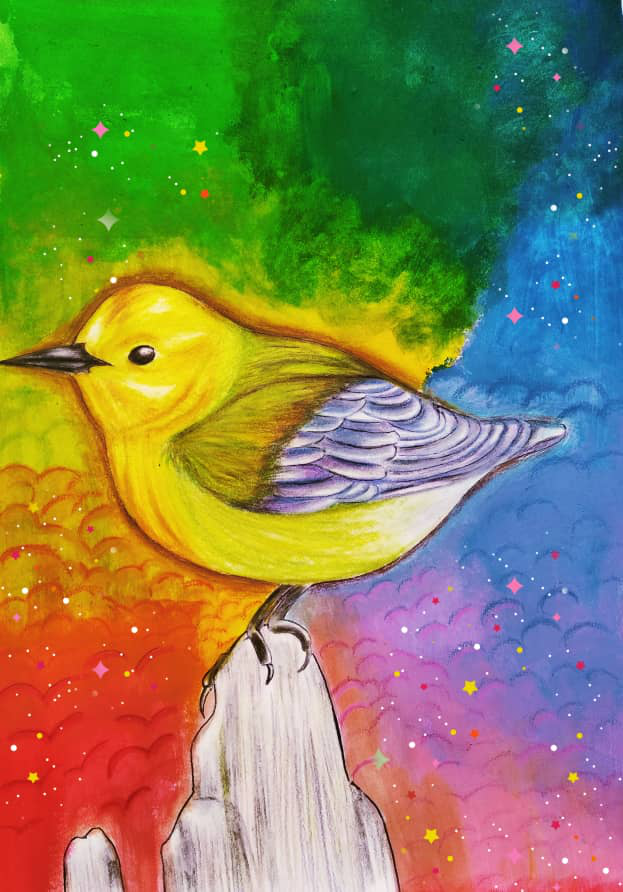

In [148]:
img

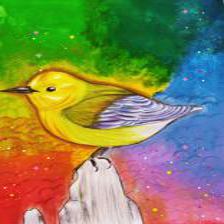

In [200]:
img = Image.open(img_path)
# img.thumbnail((IMG_SIZE, IMG_SIZE))
# img.save('test.jpg')
test.resize((IMG_SIZE, IMG_SIZE))

In [219]:
set([Path(path).suffix for path in df_imgs['path']])

{'.GIF', '.JPG', '.PNG', '.jfif', '.jpeg', '.jpg', '.png', '.webp'}

In [220]:
# for path in df_imgs['path']:
#     path = Path(path)
#     if path.suffix in ['.JPG', '.PNG', '.jpeg', '.jpg', '.png']:
#         Image.open(path).resize((IMG_SIZE, IMG_SIZE)).save(Path.joinpath(Path.cwd().parent, 'dataset', 'resized', path.name))

C:\Users\ZM\anaconda3\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\ZM\anaconda3\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (144000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\ZM\anaconda3\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (133330000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\ZM\anaconda3\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (99626400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\ZM\anaconda3\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (90552309 pixels) exceeds limit of 89478485 pixels, could be decompression bomb D

In [85]:
from keras.models import Model, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import TensorBoard, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import mobilenet_v2
PREPROCESSING_FUNCTION = mobilenet_v2.preprocess_input

IMG_SIZE = 224
BATCH_SIZE = 16
VAL_SPLIT = 0.20

In [79]:
df_imgs['path'] = df_imgs['path'].map(lambda x: str(Path.joinpath(Path.cwd().parent, x)))

In [223]:
df_imgs['path'][0]

'C:\\Users\\ZM\\Desktop\\project 2\\dataset\\image\\QmegjZDN2gyD9A6cG4efj8DwbLLGTW6isDGadNC2yVJHfH.jpg'

In [224]:
df_imgs['path'] = df_imgs['path'].map(lambda x: x.replace('image', 'resized'))

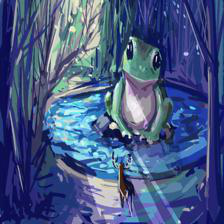

In [228]:
Image.open(df_imgs['path'][0])

In [227]:
df_imgs

,title,name,creator,art_series,price,symbol,type,likes,nsfw,tokens,year,rights,royalty,cid,path
0,30 min Drawings,Giant Frog,kristyglas,kristyglas_30-min-drawings_giant-frog,-0.001262,SWAP.HIVE,PHOTO,2,False,30,2020,1,0,QmegjZDN2gyD9A6cG4efj8DwbLLGTW6isDGadNC2yVJHfH,C:\Users\ZM\Desktop\project 2\dataset\resized\...
1,Dream World,A Guide in my Dreams,yoslehz,yoslehz_dream-world_a-guide-in-my-dreams,-0.008836,SWAP.HIVE,PHOTO,1,False,2,2020,1,0,QmUTicJApSyByFb7sgsNa6cz8MG5RKsHvGLP61gxSF3JsN,C:\Users\ZM\Desktop\project 2\dataset\resized\...
2,Dream World,I found colors in my sky,yoslehz,yoslehz_dream-world_i-found-colors-in-my-sky,-0.008836,SWAP.HIVE,PHOTO,0,False,2,2020,1,0,QmT36BPdeJWNEdUr566z4DYGWxXqrDSeoA7zCHbKw8528w,C:\Users\ZM\Desktop\project 2\dataset\resized\...
3,experimental,Angela 👼,elias15g,elias15g_experimental_angela-,-0.005049,SWAP.HIVE,PHOTO,3,False,5,2020,1,0,QmWQGXNu47pecHGfEatd3ATakphq5zXVrzs5unYYK4VR1c,C:\Users\ZM\Desktop\project 2\dataset\resized\...
4,DIGIT,MONAPIZZA,drew0,drew0_digit_monapizza,-0.011487,SWAP.HIVE,PHOTO,3,False,3,2020,3,0,Qma6eHAWkXhrkHsfCHrYJNkuPoUAFrSjg2a6Xk2sCM7CBd,C:\Users\ZM\Desktop\project 2\dataset\resized\...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,Mouse Fetish,Marble Triple Click,rubenalexander,rubenalexander_mouse-fetish_marble-triple-click,0.042939,SWAP.HIVE,PHOTO,0,False,5,2020,1,0,Qmbk1o7v6gxu9nVAPNfji1gWbQBT4JD9mkEKBLg46soEgP,C:\Users\ZM\Desktop\project 2\dataset\resized\...
2947,The beauty,Girl in garden.,alexa.art,alexa.art_the-beauty_girl-in-garden,-0.010351,SWAP.HIVE,PHOTO,0,False,7,2020,1,0,QmYE2JsNxWbfqg3sYAfsxo84UkqBRixxTFmgBHLGSdbbhy,C:\Users\ZM\Desktop\project 2\dataset\resized\...
2948,Abstract Erotica,Taste of Heaven,tntdabomb,tntdabomb_abstract-erotica_taste-of-heaven,-0.001262,SWAP.HIVE,PHOTO,0,False,10,2020,3,0,QmeNbzcYHKDzZFTuY3PqBPr5WGKMGmrjrTsKDKd7WTe422,C:\Users\ZM\Desktop\project 2\dataset\resized\...
2949,Eye,Eye Of The Beholder,rubenalexander,rubenalexander_eye_eye-of-the-beholder,-0.001262,SWAP.HIVE,PHOTO,0,False,3,2020,1,0,QmWTT58erwH6Vtv8UJNNM6mmWuwZNsWAYygRXmHnpJeeBa,C:\Users\ZM\Desktop\project 2\dataset\resized\...


In [226]:
datagen = ImageDataGenerator(
    preprocessing_function=PREPROCESSING_FUNCTION,
    validation_split=VAL_SPLIT,
)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_imgs,
    x_col='path',
    y_col='price',
    subset='training',
#     target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='raw',
    shuffle=True,
    batch_size=BATCH_SIZE,
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df_imgs,
    x_col='path',
    y_col='price',
    subset='validation',
#     target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='raw',
    shuffle=False,
    batch_size=BATCH_SIZE,
)

C:\Users\ZM\AppData\Roaming\Python\Python38\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 12 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 2352 validated image filenames.
Found 587 validated image filenames.


In [104]:
pretrained_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
PRETRAINED_NAME = pretrained_model.name.split('_')[0]

for layer in pretrained_model.layers: layer.trainable = False

mobilenetv2
10Dec-2232
Epoch 1/100
147/147 [==============================] - 66s 312ms/step - loss: 7.5251 - accuracy: 0.0077 - val_loss: 0.0579 - val_accuracy: 0.0034

Epoch 00001: val_loss improved from inf to 0.05795, saving model to C:\Users\ZM\Desktop\project 2\src\models\model_loss.h5


C:\Users\ZM\AppData\Roaming\Python\Python38\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
147/147 [==============================] - 23s 159ms/step - loss: 2.1504 - accuracy: 0.0081 - val_loss: 0.0573 - val_accuracy: 0.0034

Epoch 00002: val_loss improved from 0.05795 to 0.05726, saving model to C:\Users\ZM\Desktop\project 2\src\models\model_loss.h5
Epoch 3/100
147/147 [==============================] - 22s 150ms/step - loss: 1.5251 - accuracy: 0.0081 - val_loss: 0.0568 - val_accuracy: 0.0034

Epoch 00003: val_loss improved from 0.05726 to 0.05675, saving model to C:\Users\ZM\Desktop\project 2\src\models\model_loss.h5
Epoch 4/100
147/147 [==============================] - 23s 156ms/step - loss: 1.5226 - accuracy: 0.0081 - val_loss: 0.0565 - val_accuracy: 0.0034

Epoch 00004: val_loss improved from 0.05675 to 0.05653, saving model to C:\Users\ZM\Desktop\project 2\src\models\model_loss.h5
Epoch 5/100
147/147 [==============================] - 22s 151ms/step - loss: 1.5204 - accuracy: 0.0081 - val_loss: 0.0566 - val_accuracy: 0.0034

Epoch 00005: val_loss did not i

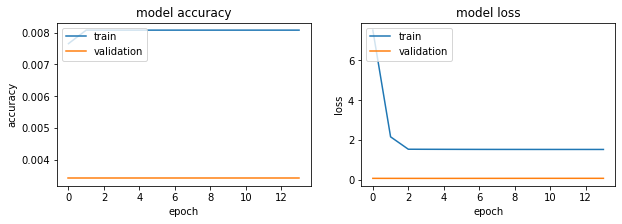

6.67 mins


In [229]:
DENSE_LAYERS = 1
DENSE_LAYER_SIZE = 32
PATIENCE = 10
DROPOUT = 0.0

x = pretrained_model.output

x = Flatten()(x)
for _ in range(DENSE_LAYERS):
    x = Dense(DENSE_LAYER_SIZE, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(DROPOUT)(x)
x = Dense(1)(x)

#------------------------------------------------------------------------------#

model = Model(inputs=pretrained_model.input, outputs=x)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model_path = Path.joinpath(Path.cwd(), 'models', 'model_loss.h5')

print(PRETRAINED_NAME)
DATETIME = time.strftime('%#d%b-%H%M')
print(DATETIME)
start = time.perf_counter()

#------------------------------ Model Callbacks -------------------------------#

earlystop = EarlyStopping(monitor='val_loss', patience=PATIENCE)
lr_stagnate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1, mode='auto')
checkpoint_loss = ModelCheckpoint(
    model_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
)
CALLBACKS = [lr_stagnate, checkpoint_loss, earlystop]

#------------------------------- Model Training -------------------------------#

hist = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=CALLBACKS,
    verbose=1,
)

#-------------------------- Training/Validation Curves ------------------------#

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot training and validation accuracy against epochs using matplotlib
ax1.plot(hist.history['accuracy'])
ax1.plot(hist.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')

# Plot training and validation loss against epochs using matplotlib
ax2.plot(hist.history['loss'])
ax2.plot(hist.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()

#------------------------------------------------------------------------------#

EPOCHS = len(hist.history['val_loss']) - PATIENCE
print(f'{duration(start)} mins')

(array([509., 608., 461., 232., 260.,  61.,  54., 137.,  40., 128.]),
 array([  2.5 ,  22.25,  42.  ,  61.75,  81.5 , 101.25, 121.  , 140.75,
        160.5 , 180.25, 200.  ]),
 <BarContainer object of 10 artists>)

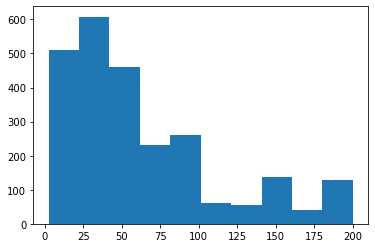

In [111]:
plt.hist(df_imgs['price'][df_imgs['price'] <= 200])

In [196]:
from sklearn.preprocessing import RobustScaler
value = 1.5
df_imgs['price'] = RobustScaler(quantile_range=(value, 100-value)).fit_transform(df_imgs['price'].values.reshape(-1,1))
df_imgs

,title,name,creator,art_series,price,symbol,type,likes,nsfw,tokens,year,rights,royalty,cid,path
0,30 min Drawings,Giant Frog,kristyglas,kristyglas_30-min-drawings_giant-frog,-0.001262,SWAP.HIVE,PHOTO,2,False,30,2020,1,0,QmegjZDN2gyD9A6cG4efj8DwbLLGTW6isDGadNC2yVJHfH,C:\Users\ZM\Desktop\project 2\dataset\image\Qm...
1,Dream World,A Guide in my Dreams,yoslehz,yoslehz_dream-world_a-guide-in-my-dreams,-0.008836,SWAP.HIVE,PHOTO,1,False,2,2020,1,0,QmUTicJApSyByFb7sgsNa6cz8MG5RKsHvGLP61gxSF3JsN,C:\Users\ZM\Desktop\project 2\dataset\image\Qm...
2,Dream World,I found colors in my sky,yoslehz,yoslehz_dream-world_i-found-colors-in-my-sky,-0.008836,SWAP.HIVE,PHOTO,0,False,2,2020,1,0,QmT36BPdeJWNEdUr566z4DYGWxXqrDSeoA7zCHbKw8528w,C:\Users\ZM\Desktop\project 2\dataset\image\Qm...
3,experimental,Angela 👼,elias15g,elias15g_experimental_angela-,-0.005049,SWAP.HIVE,PHOTO,3,False,5,2020,1,0,QmWQGXNu47pecHGfEatd3ATakphq5zXVrzs5unYYK4VR1c,C:\Users\ZM\Desktop\project 2\dataset\image\Qm...
4,DIGIT,MONAPIZZA,drew0,drew0_digit_monapizza,-0.011487,SWAP.HIVE,PHOTO,3,False,3,2020,3,0,Qma6eHAWkXhrkHsfCHrYJNkuPoUAFrSjg2a6Xk2sCM7CBd,C:\Users\ZM\Desktop\project 2\dataset\image\Qm...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,Mouse Fetish,Marble Triple Click,rubenalexander,rubenalexander_mouse-fetish_marble-triple-click,0.042939,SWAP.HIVE,PHOTO,0,False,5,2020,1,0,Qmbk1o7v6gxu9nVAPNfji1gWbQBT4JD9mkEKBLg46soEgP,C:\Users\ZM\Desktop\project 2\dataset\image\Qm...
2947,The beauty,Girl in garden.,alexa.art,alexa.art_the-beauty_girl-in-garden,-0.010351,SWAP.HIVE,PHOTO,0,False,7,2020,1,0,QmYE2JsNxWbfqg3sYAfsxo84UkqBRixxTFmgBHLGSdbbhy,C:\Users\ZM\Desktop\project 2\dataset\image\Qm...
2948,Abstract Erotica,Taste of Heaven,tntdabomb,tntdabomb_abstract-erotica_taste-of-heaven,-0.001262,SWAP.HIVE,PHOTO,0,False,10,2020,3,0,QmeNbzcYHKDzZFTuY3PqBPr5WGKMGmrjrTsKDKd7WTe422,C:\Users\ZM\Desktop\project 2\dataset\image\Qm...
2949,Eye,Eye Of The Beholder,rubenalexander,rubenalexander_eye_eye-of-the-beholder,-0.001262,SWAP.HIVE,PHOTO,0,False,3,2020,1,0,QmWTT58erwH6Vtv8UJNNM6mmWuwZNsWAYygRXmHnpJeeBa,C:\Users\ZM\Desktop\project 2\dataset\image\Qm...


In [197]:
df_imgs.describe()

,price,likes,tokens,year,rights,royalty
count,2951.000000,2951.000000,2951.000000,2951.000000,2951.000000,2951.0
mean,0.108206,0.483226,4.085734,2019.193833,1.580142,0.0
std,1.104045,0.926250,10.440425,38.291271,0.907744,0.0
min,-0.013254,0.000000,1.000000,20.000000,1.000000,0.0
25%,-0.006439,0.000000,1.000000,2020.000000,1.000000,0.0
50%,0.000000,0.000000,3.000000,2020.000000,1.000000,0.0
75%,0.023984,1.000000,5.000000,2021.000000,3.000000,0.0
max,25.232265,7.000000,500.000000,2578.000000,3.000000,0.0
